# Code Summary

# This notebook adheres to TRIPOD Criteria

# Preprocess Data 
    # select data (A_ variables or non-A_ variables)
    # select the label (y) and remove it from the dataset (X)
    # exclude future variables
    # exclude variables more than 50% blank
    # train/test split (80:20)
    # make a dictionary of which variables are continuous vs ordinal vs categorical
    # normalize training continuous variables to be mean centered on 0, std_dev = 1
    # keep ordinal variables as is (but map unknown or NaN to 99 or -1 or 0)
    # one-hot encoding of categorical variables
    # apply the same training normalization to test data
# Visualize data
    # Plot some initial data distributions
    # Plot covariance matrix heatmap showing which variables correlate most with outcome variables
# Train/Validate
    # Select 5 algorithms which can take normalized continuous variables and one-hot encoded categorical variables and output a probability
    # 1. XGBoost (Extreme Gradient Boosting), 2. LightGBM, 3. CatBoost, 4. Neural Networks, 5. Gradient Boosting Classifier (e.g., scikit-learn's GradientBoostingClassifier)
    # Bootstrapped nested k-fold cross-validation (100-fold bootstrap, k=5, score should be the ROC-AUC score)
    # For the nested part, select a random range of hyperparameters appropriate for each of the 5 algorithms, with 20 different hyperparameter combinations total per algorithm
    # Plot progress bars showing training progress
    # Plot one bar plot per algorithm of performance vs training param combination (thus the x-axis should have 20 ticks)
    # Print out the best hyperparameter combinations for each algorithm
    # Use stacking to get a single aggregate score based on all the 5 models with the best hyperparameter scores
    # Display Results
        # Plot ROC-AUC plot showing the best bootstrapped nested k-fold cross-validation (ROC-AUC) score of each of the 5 algorithms + the 1 stacking algorithm score
        # Plot bar plot showing the best bootstrapped nested k-fold cross-validation (ROC-AUC) score of each of the 5 algorithms + the 1 stacking algorithm score with error bars giving the 95% CI from bootstrapping
        # Convert label probability into binary label (>=0.5 = 1, <0.5 = 0)
        # Use binary labels to get accuracy, sensitivity, specificity, F1-score, and plot confusion matrix
    # Retrain the 5 models (with best hyperparams) and stacked model on the full train dataset (with progress bar)
    # Save the final trained 5 models and stacked model
# Test
    # Use the stacked model and all 5 final trained models to predict the label in the held-out test set
    # Use 100-fold bootstrapping of test set to get 95% CI
    # Display Results
        # Plot ROC-AUC plot showing the best bootstrapped nested k-fold cross-validation (ROC-AUC) score of each of the 5 algorithms + the 1 stacking algorithm score
        # Plot bar plot showing the best bootstrapped nested k-fold cross-validation (ROC-AUC) score of each of the 5 algorithms + the 1 stacking algorithm score with error bars giving the 95% CI from bootstrapping
        # Convert label probability into binary label (>=0.5 = 1, <0.5 = 0)
        # Use binary labels to get accuracy, sensitivity, specificity, F1-score, and plot confusion matrix
     

In [1]:
# save data - done
# add linear regression
# smote fix - done
# find decision threshold - done
# compare high and low risk groups by decision boundary - done
# subgroup analysis over age and race - done
# calibration curves - done
# run with 30 day mortality - implemented, need to run
# sensitivity analysis with train:test split over time (earliest 80% dx cases will be train, later 20% test) - implemented, need to run
# sensitivity analysis with and without feature reduction - implemented, need to run
# SHAP - sorta implemented... needs work...

In [2]:
from ent_utils import *

'''
Toggle experiment settings here
'''

# Record the start time
start_time = datetime.datetime.now()

experiment_name = "30d_readmis"  # Set your experiment name, if any

use_mini_dataset = False
# use_mini_dataset = True # Set to True for testing with a mini-train and test dataset (first 500 entries of each)

dataset_option = "use_full_ncbd_dataset"
# dataset_option = "use_selected_A_dataset" # Use selected A variables only

outcome_option = "use_30_day_readmission"; class_labels = ['No Readmission','Readmission within 30 Days']; outcome_name = 'READM_HOSP_30_DAYS'
# outcome_option = "use_30_day_mortality"; class_labels = ['Living','Deceased within 30 Days']; outcome_name = 'PUF_30_DAY_MORT_CD'
# outcome_option = "use_90_day_mortality"; class_labels = ['Living','Deceased within 90 Days']; outcome_name = 'PUF_90_DAY_MORT_CD'

split_by_dx_date=False
# split_by_dx_date=True # Set to True for sensitivity analysis for spliting by diagnosis date: train (early cases) vs test (late cases)

exclude_variables_more_than_x_proportion_blank = 0.5

train_test_split = [80,20]

use_lasso = True; use_rfe = False; use_rf = False; use_boruta = False; overlap_mode="all_overlap"

# use_PCA = True
use_PCA = False

n_bootstraps_for_training = 10
n_bootstraps_for_results = 100
num_k_fold_splits = 5

if use_mini_dataset:
    n_bootstraps_for_training = 2
    n_bootstraps_for_results = 5
    num_k_fold_splits = 2

2024-07-02 10:31:32.048653: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load the database .sav file
df, meta = pyreadstat.read_sav("Aman_NCDB_30_day_ML_MSGC_Database.sav")


In [4]:
# '''
# Show data distribution and basic statistics
# '''

# visualize_demographics(df)

# # Print out all the column names of the DataFrame
# print(df.columns.tolist())

# # Generate data summaries
# demographic_summaries, age_stats, ln_stats = summarize_demographics(df)

# print("Age Statistics:")
# display(age_stats)

# print("Lymph Node Statistics:")
# display(ln_stats)

# print("\nDemographic Summaries:")
# for key, value in demographic_summaries.items():
#     print(f"\n{key}:")
#     display(value)


In [5]:
# Preprocess Data 
    # select data (A_ variables or non-A_ variables)
    # select the label (y) and remove it from the dataset (X)
    # exclude future variables
    # exclude variables more than 50% blank
    # train/test split (80:20)
    # make a dictionary of which variables are continuous vs ordinal vs categorical
    # normalize training continuous variables to be mean centered on 0, std_dev = 1
    # keep ordinal variables as is (but map unknown or NaN to 99 or -1 or 0)
    # one-hot encoding of categorical variables
    # apply the same training normalization to test data
    
X, y = filter_variables(df,
                       dataset_option,
                       outcome_option, 
                       exclude_variables_more_than_x_proportion_blank, 
                       verbose=True, 
                       plot_histogram=False)

print('Final columns')
print(X.columns.tolist())

Using full NCBD dataset
Removing "A_" variables
Outcome is 30 d readmission
Number of entries excluded due to missing outcomes: 0
Removing treatment-related variables
Excluded variables and their proportion of blanks:
CS_METS_DX_BONE: 51.23%
CS_METS_DX_BRAIN: 51.23%
CS_METS_DX_LIVER: 51.23%
CS_METS_DX_LUNG: 51.23%
DX_STAGING_PROC_DAYS: 66.75%
MED_INC_QUAR_2020: 100.00%
METS_AT_DX_BONE: 73.93%
METS_AT_DX_BRAIN: 73.93%
METS_AT_DX_DISTANT_LN: 73.93%
METS_AT_DX_LIVER: 73.93%
METS_AT_DX_LUNG: 73.93%
METS_AT_DX_OTHER: 73.93%
NO_HSD_QUAR_2020: 100.00%
SCHEMA_DISC_1: 100.00%
SCHEMA_DISC_2: 100.00%
SCHEMA_DISC_3: 100.00%
SLN_EXAM: 100.00%
SLN_POS: 100.00%
Final columns
['ADENOID_CYSTIC_BSLD', 'ADENOPATHY', 'AFP_POST_ORCH_RANGE', 'AFP_POST_ORCH_VALUE', 'AFP_PRE_INTERP', 'AFP_PRE_ORCH_RANGE', 'AFP_PRE_ORCH_VALUE', 'AFP_PRE_VALUE', 'AGE', 'AJCC_ID', 'AJCC_TNM_CLIN_M', 'AJCC_TNM_CLIN_N', 'AJCC_TNM_CLIN_N_SFX', 'AJCC_TNM_CLIN_STG_GRP', 'AJCC_TNM_CLIN_T', 'AJCC_TNM_CLIN_T_SFX', 'AJCC_TNM_PATH_M', 'AJ

In [6]:
# Train:test split:
    # split using train_test_split variable = [80:20]
X_train_raw, y_train_raw, X_test_raw, y_test_raw = custom_train_test_split(X,y,train_test_split,split_by_dx_date=split_by_dx_date)

# Merging X and y datasets for both train and test and saving train/test data as .sav files
train_data = pd.merge(X_train_raw, y_train_raw, left_index=True, right_index=True); test_data = pd.merge(X_test_raw, y_test_raw, left_index=True, right_index=True)
# Save train and test data as SPSS .sav file
pyreadstat.write_sav(train_data, f'{experiment_name}_train_data.sav'); pyreadstat.write_sav(test_data, f'{experiment_name}_test_data.sav')

# Data normalization:
    # make a dictionary of which variables are continuous vs ordinal vs categorical
        # normalize training continuous variables to be mean centered on 0, std_dev = 1
        # keep ordinal variables as is (but map unknown or NaN to 99 or -1 or 0)
        # one-hot encoding of categorical variables
    # apply the same training normalization to test data

X_train, X_test = normalize(X_train_raw, X_test_raw)

# Outcome binarization:
    # Values of 0 will stay as 0
    # Values >= 1 will become 1

y_train, y_test = binarize(y_train_raw, y_test_raw)


In [7]:
# Calculate the proportions
train_positives_percentage = (np.sum(y_train) / len(y_train)) * 100; train_negatives_percentage = 100 - train_positives_percentage
test_positives_percentage = (np.sum(y_test) / len(y_test)) * 100; test_negatives_percentage = 100 - test_positives_percentage

# Format and print the proportions
print(f"Train data: {train_positives_percentage:.2f}%:{train_negatives_percentage:.2f}% positive:negative cases")
print(f"Test data: {test_positives_percentage:.2f}%:{test_negatives_percentage:.2f}% positive:negative cases")


Train data: 3.38%:96.62% positive:negative cases
Test data: 3.45%:96.55% positive:negative cases


In [8]:
# Optionally reduce the number of features using various feature reduction methods
X_train,X_test = feature_reduction(use_lasso,use_rfe,use_rf,use_boruta,X_train,X_test,y_train,y_test,overlap_mode="all_overlap")     




There are 1107 features in the training data.


/Users/DanielFu/miniconda3/envs/aman/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06960837565975453, tolerance: 0.05559106267029978
  model = cd_fast.enet_coordinate_descent_gram(
/Users/DanielFu/miniconda3/envs/aman/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1581872860639919, tolerance: 0.05559106267029978
  model = cd_fast.enet_coordinate_descent_gram(
/Users/DanielFu/miniconda3/envs/aman/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2196604447703976, tolerance: 0.05559106267029978
  model = cd_fast.enet_coordinate_descent_gram(
/Users/DanielFu

/Users/DanielFu/miniconda3/envs/aman/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1019494829154155, tolerance: 0.053541705013320395
  model = cd_fast.enet_coordinate_descent_gram(
/Users/DanielFu/miniconda3/envs/aman/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08590104263981857, tolerance: 0.053541705013320395
  model = cd_fast.enet_coordinate_descent_gram(
/Users/DanielFu/miniconda3/envs/aman/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07642693106720344, tolerance: 0.053541705013320395
  model = cd_fast.enet_coordinate_descent_gram(
/Users/Dani



Lasso regression selected 69 important features in the training data.


After combining overlapping reduced features from multiple methods, 69 features remain.


X_train and X_test now have 69 features each from the feature reduction.


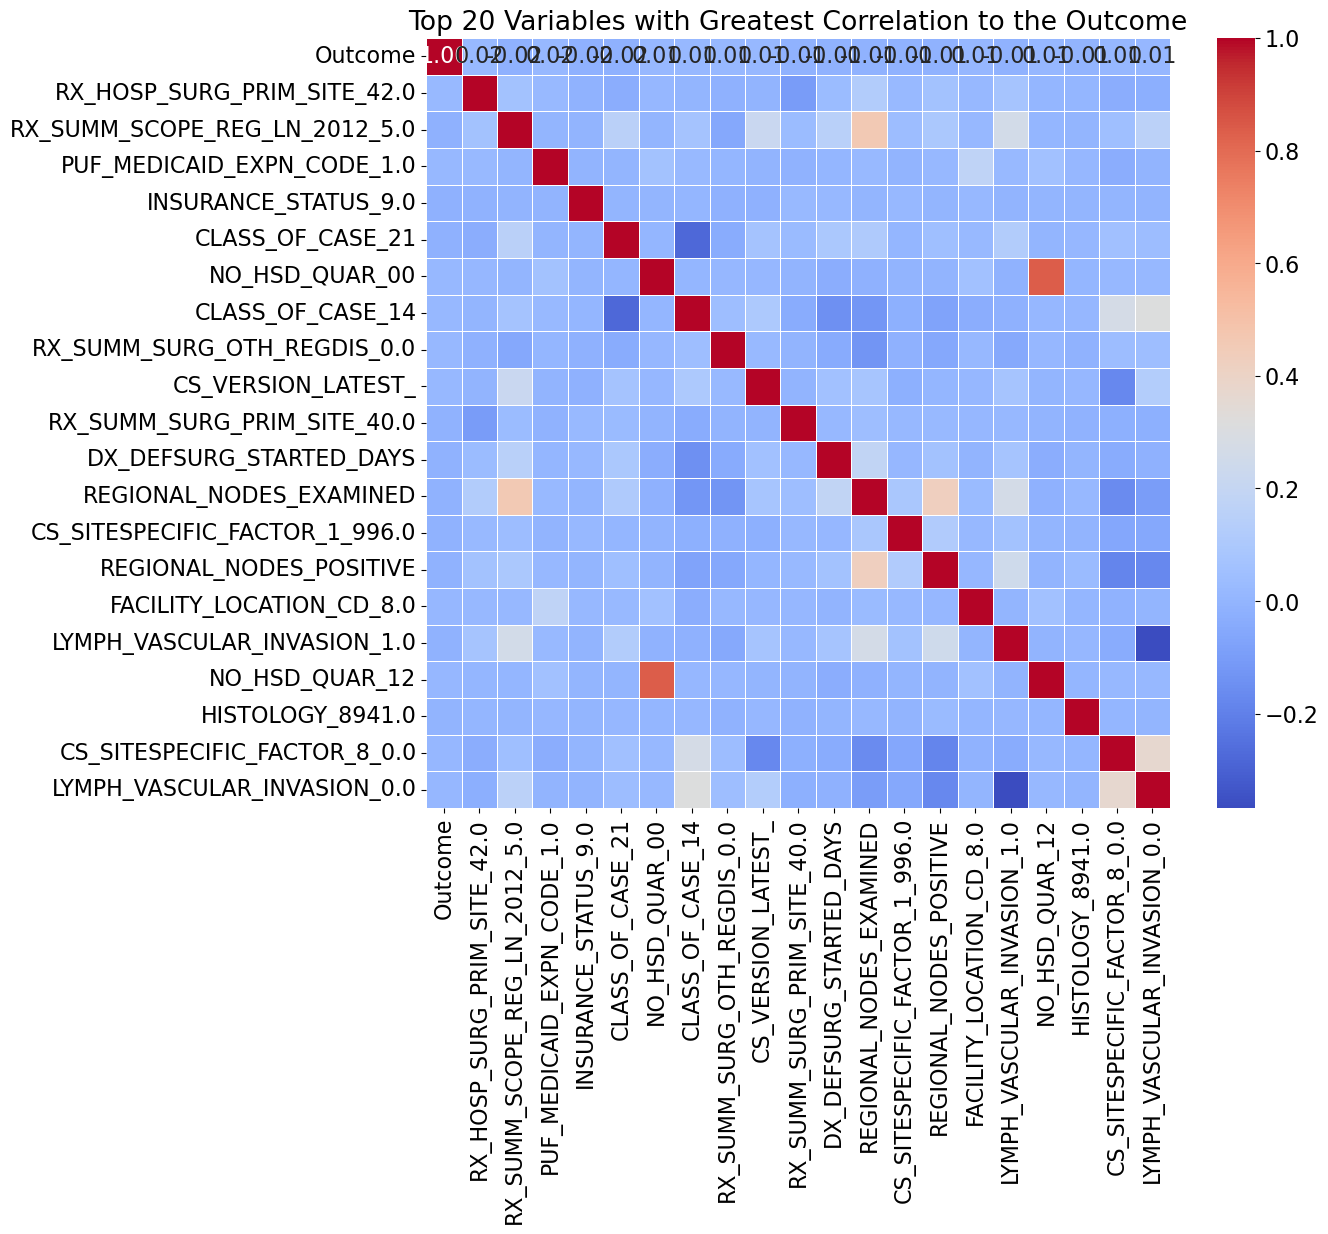

In [9]:
# Plot the covariance heatmap after feature reduction (or after preprocessing if feature reduction was not performed)
plot_covariance_heatmap(X_train, y_train, top_n=20)

In [10]:
# Optionally use PCA to transform the data features into principal component space
if use_PCA:
    X_train,X_test = pca_transform(X_train,X_test)

# Use SMOTE to resample the training data to make it more balanced
X_train,y_train = SMOTE_resample(X_train, X_test, y_train, y_test, sampling_strategy=0.2)

print('Data processing complete')
print('X_train shape: ',X_train.shape); print('X_test shape: ',X_test.shape); print('y_train shape: ',y_train.shape); print('y_test shape: ',y_test.shape)

# Save the variables to a file
with open(f'{experiment_name}_data_variables.pkl', 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)

print('Final columns')
print(X.columns.tolist())



There are 698.0 or 3% positive examples of out 20644 samples in the training data.
There are 178.0 or 3% positive examples of out 5161 samples in the test data.


After SMOTE there are 3989.0 or 17% positive examples in the training data out of 23935 samples in the training data.
Data processing complete
X_train shape:  (23935, 69)
X_test shape:  (5161, 69)
y_train shape:  (23935,)
y_test shape:  (5161,)
Final columns
['ADENOID_CYSTIC_BSLD', 'ADENOPATHY', 'AFP_POST_ORCH_RANGE', 'AFP_POST_ORCH_VALUE', 'AFP_PRE_INTERP', 'AFP_PRE_ORCH_RANGE', 'AFP_PRE_ORCH_VALUE', 'AFP_PRE_VALUE', 'AGE', 'AJCC_ID', 'AJCC_TNM_CLIN_M', 'AJCC_TNM_CLIN_N', 'AJCC_TNM_CLIN_N_SFX', 'AJCC_TNM_CLIN_STG_GRP', 'AJCC_TNM_CLIN_T', 'AJCC_TNM_CLIN_T_SFX', 'AJCC_TNM_PATH_M', 'AJCC_TNM_PATH_N', 'AJCC_TNM_PATH_N_SFX', 'AJCC_TNM_PATH_STG_GRP', 'AJCC_TNM_PATH_T', 'AJCC_TNM_PATH_T_SFX', 'AJCC_TNM_POST_PATH_M', 'AJCC_TNM_POST_PATH_N', 'AJCC_TNM_POST_PATH_N_SFX', 'AJCC_TNM_POST_PATH_STG_GRP', 'AJCC_TNM_POST_PATH_T', 'AJCC_TNM

In [11]:
'''
Select 5 algorithms which can take normalized continuous variables and one-hot encoded categorical variables and output a probability
    1. XGBoost (Extreme Gradient Boosting)
    2. SGD Logistic Regression
    3. Logistic Regression
    4. CatBoost
    5. SVC
    (6.) LightGBM - too much memory requirement
    (7.) Neural Networks - too computationally expensive
    (8.) Gradient Boosting Classifier (e.g., scikit-learn's GradientBoostingClassifier) - too computationally expensive
Bootstrapped nested k-fold cross-validation (100-fold bootstrap, k=5, score should be the ROC-AUC score)
For the nested part, select a random range of hyperparameters appropriate for each of the 5 algorithms, with 20 different hyperparameter combinations total per algorithm
Plot progress bars showing training progress
Meh - Plot one bar plot per algorithm of ROC-AUC vs training param combination (thus the x-axis should have 20 ticks)
Print out the best hyperparameter combinations for each algorithm
Use stacking to get a single aggregate score based on all the 5 models with the best hyperparameter scores
Display Results
    Plot ROC-AUC plot showing the best bootstrapped nested k-fold cross-validation (ROC-AUC) score of each of the 5 algorithms + the 1 stacking algorithm score
    Plot bar plot showing the best bootstrapped nested k-fold cross-validation (ROC-AUC) score of each of the 5 algorithms + the 1 stacking algorithm score with error bars giving the 95% CI from bootstrapping
    Convert label probability into binary label (>=0.5 = 1, <0.5 = 0)
    Use binary labels to get accuracy, sensitivity, specificity, F1-score, and plot confusion matrix
Retrain the 5 models (with best hyperparams) and stacked model on the full train dataset (with progress bar)
Save the final trained 5 models and stacked model
    '''
# # Load the variables back from the file
# with open(f'{experiment_name}_data_variables.pkl', 'rb') as f:
#     X_train, X_test, y_train, y_test = pickle.load(f)

X_small = X_train[:500] # small version for testing
y_small = y_train[:500].ravel() # small version for testing

# Dictionary to collect all_models from each iteration
all_models = {}

# Iterate over each sub-dictionary in models_hyperparams
for model_name, model_hyperparams in models_hyperparams.items():
    save_filename = f'{experiment_name}_{model_name}_results_and_cv_model.pkl'
    
    # Check if this model's combined file already exists, if so, load it
    try:
        with open(save_filename, 'rb') as file:
            combined_data = pickle.load(file)
        results = combined_data["results"]
        model = combined_data["model"]
        print(f"Loaded saved combined file for {model_name}")
    except:
        # If not found, process, save, and combine this model and results
        if use_mini_dataset:
            results, model = process_and_save_combined(model_name, model_hyperparams, X_small, y_small, n_bootstraps_for_training, num_k_fold_splits, experiment_name)
        else:
            results, model = process_and_save_combined(model_name, model_hyperparams, X_train, y_train, n_bootstraps_for_training, num_k_fold_splits, experiment_name)
        print(f"Processed, saved, and combined for {model_name}")
    
    # Collect this model
    all_models.update(model)


Loaded saved combined file for XGBoost
Loaded saved combined file for CatBoost
Loaded saved combined file for Logistic Regression
Loaded saved combined file for SGD Logistic Regression
Loaded saved combined file for Gradient Boosting


In [ ]:
# Create a stacked model which incorporates all models
stacked_model = stack_models(all_models)
trained_stacked_model = None
trained_all_models = None

# Check if this model's combined file already exists, if so, load it
save_filename = f'models/{experiment_name}_trained_stacked_model.pkl'
try:
    # Load stacked_model
    with open(f'/models/{experiment_name}_trained_stacked_model.pkl', 'rb') as file:
        trained_stacked_model = pickle.load(file)

    # Load all_models
    with open(f'/models/{experiment_name}_trained_all_models.pkl', 'rb') as file:
        trained_all_models = pickle.load(file)
    print(f"Loaded saved trained models for {experiment_name}")
except:
    print('Retraining all models plus stacked model on the full training dataset...')
    if use_mini_dataset:
        trained_stacked_model, trained_all_models = retrain_models(stacked_model, all_models, 
                                                               X_small, y_small)
    else:
        trained_stacked_model, trained_all_models = retrain_models(stacked_model, all_models, 
                                                               X_train, y_train)
    # Save stacked_model
    with open(f'models/{experiment_name}_trained_stacked_model.pkl', 'wb') as file:
        pickle.dump(trained_stacked_model, file)
    # Save all_models
    with open(f'models/{experiment_name}_trained_all_models.pkl', 'wb') as file:
        pickle.dump(trained_all_models, file)


Retraining all models plus stacked model on the full training dataset...


Training performance results


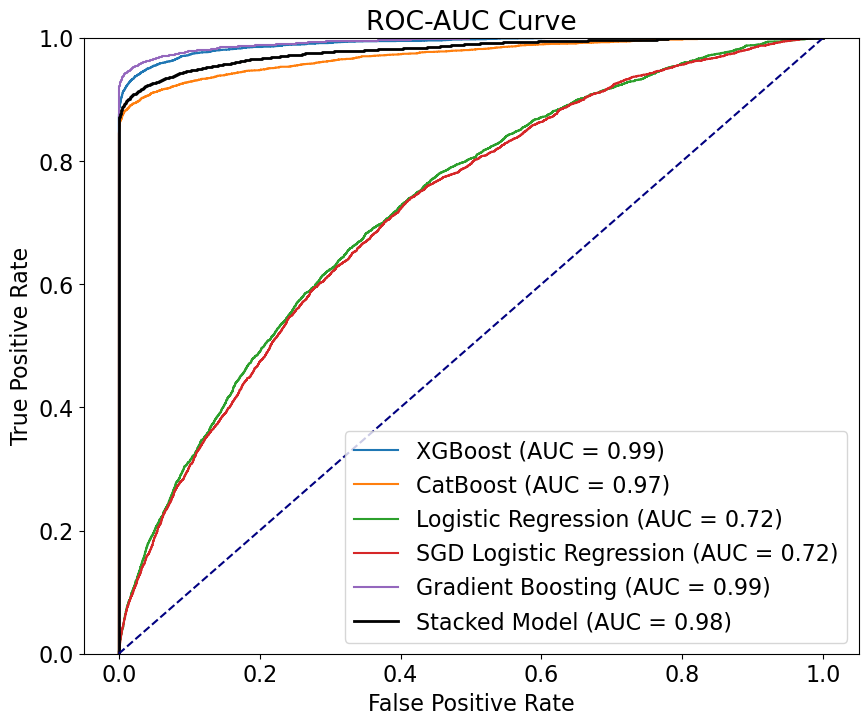

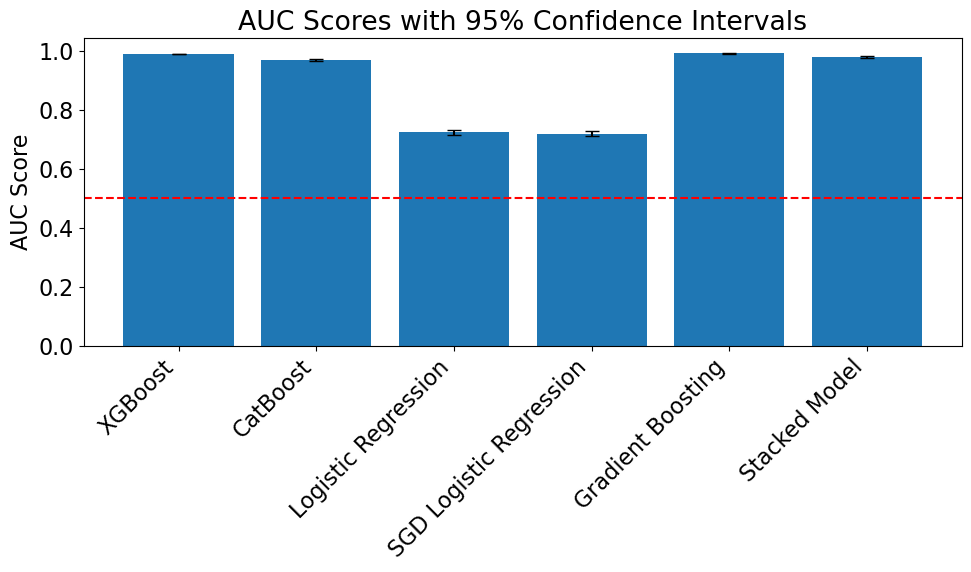

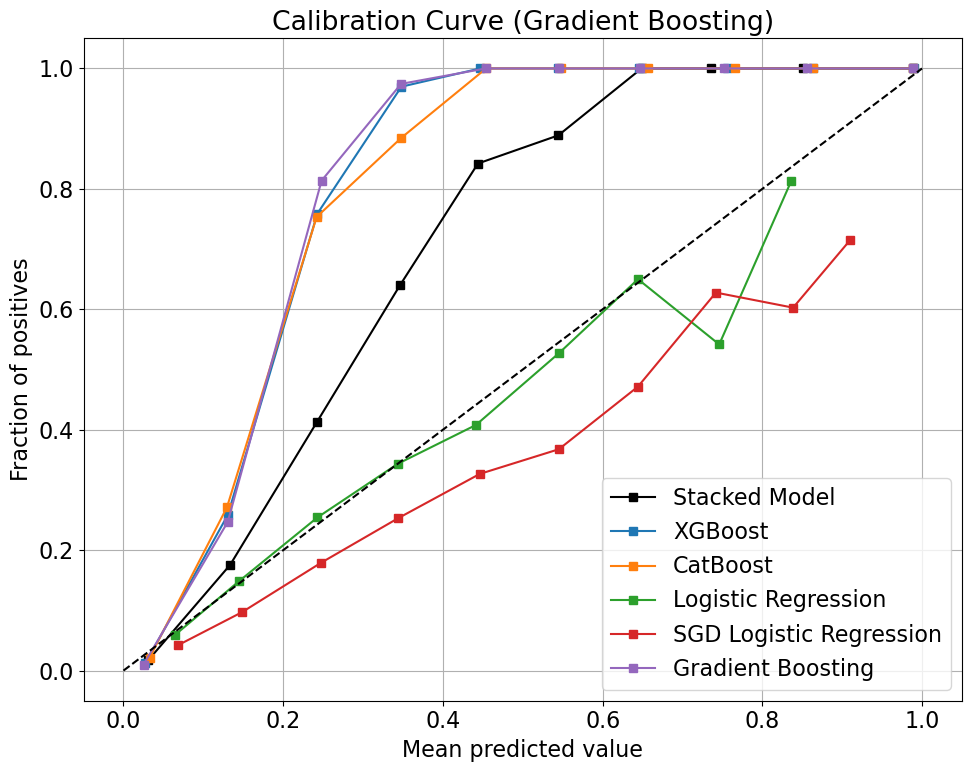

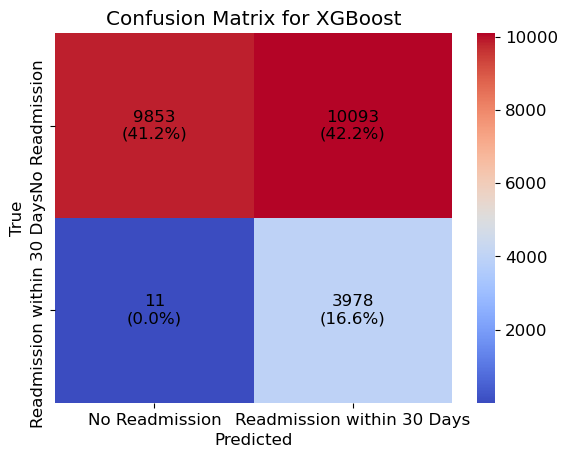


XGBoost:
AUC: 0.99 (95% CI: 0.99-0.99)
Accuracy: 0.58 (95% CI: 0.57-0.58)
Sensitivity: 1.00 (95% CI: 1.00-1.00)
Specificity: 0.49 (95% CI: 0.49-0.50)
F1-Score: 0.44 (95% CI: 0.43-0.45)
Relative Risk: 253.51 (95% CI: 159.80-562.40)
Absolute Risk High: 0.2827 (95% CI: 0.2747-0.2904)
Absolute Risk Low: 0.0011 (95% CI: 0.0005-0.0018)
Attributable Risk: 0.2816 (95% CI: 0.2737-0.2891)
P-value for group comparison: 0.000000000


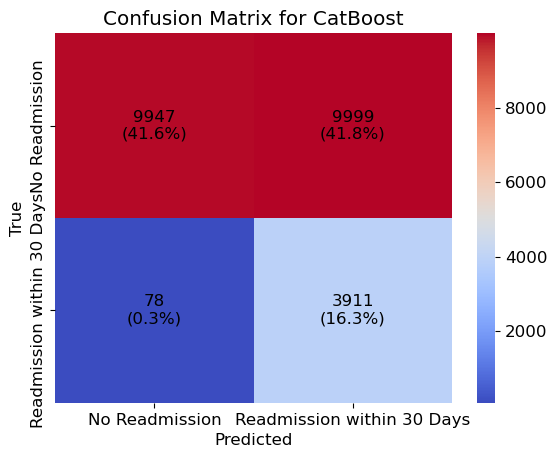


CatBoost:
AUC: 0.97 (95% CI: 0.97-0.97)
Accuracy: 0.58 (95% CI: 0.57-0.59)
Sensitivity: 0.98 (95% CI: 0.98-0.98)
Specificity: 0.50 (95% CI: 0.49-0.51)
F1-Score: 0.44 (95% CI: 0.43-0.45)
Relative Risk: 36.14 (95% CI: 29.28-46.77)
Absolute Risk High: 0.2812 (95% CI: 0.2740-0.2884)
Absolute Risk Low: 0.0078 (95% CI: 0.0060-0.0096)
Attributable Risk: 0.2734 (95% CI: 0.2660-0.2808)
P-value for group comparison: 0.000000000


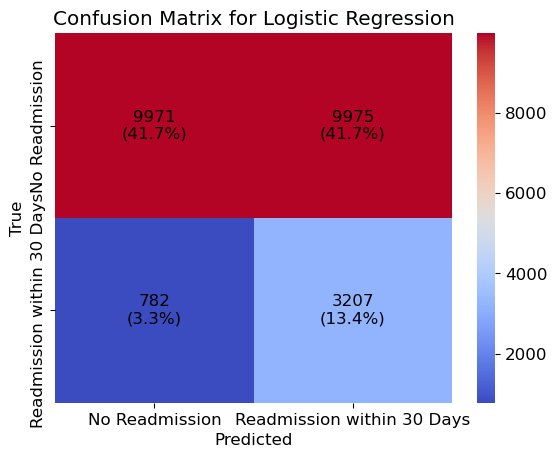


Logistic Regression:
AUC: 0.72 (95% CI: 0.72-0.73)
Accuracy: 0.55 (95% CI: 0.54-0.56)
Sensitivity: 0.80 (95% CI: 0.79-0.82)
Specificity: 0.50 (95% CI: 0.49-0.51)
F1-Score: 0.37 (95% CI: 0.37-0.38)
Relative Risk: 3.35 (95% CI: 3.12-3.67)
Absolute Risk High: 0.2433 (95% CI: 0.2376-0.2512)
Absolute Risk Low: 0.0727 (95% CI: 0.0677-0.0774)
Attributable Risk: 0.1706 (95% CI: 0.1627-0.1803)
P-value for group comparison: 0.000000000


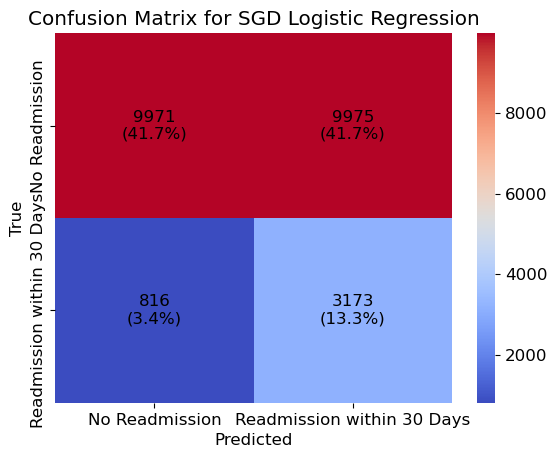


SGD Logistic Regression:
AUC: 0.72 (95% CI: 0.71-0.73)
Accuracy: 0.55 (95% CI: 0.54-0.56)
Sensitivity: 0.80 (95% CI: 0.78-0.81)
Specificity: 0.50 (95% CI: 0.49-0.51)
F1-Score: 0.37 (95% CI: 0.36-0.38)
Relative Risk: 3.19 (95% CI: 3.01-3.46)
Absolute Risk High: 0.2413 (95% CI: 0.2357-0.2500)
Absolute Risk Low: 0.0756 (95% CI: 0.0704-0.0800)
Attributable Risk: 0.1657 (95% CI: 0.1589-0.1770)
P-value for group comparison: 0.000000000


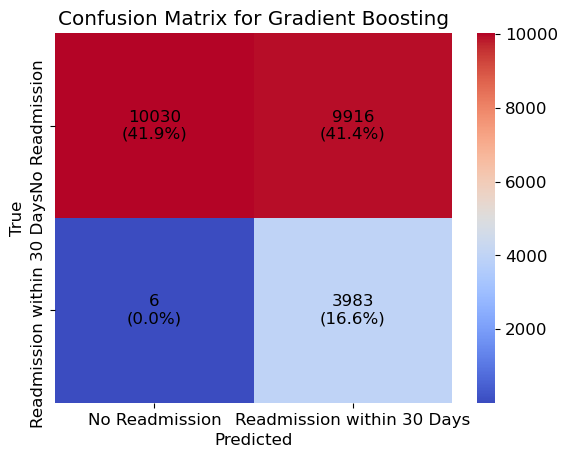


Gradient Boosting:
AUC: 0.99 (95% CI: 0.99-0.99)
Accuracy: 0.59 (95% CI: 0.58-0.59)
Sensitivity: 1.00 (95% CI: 1.00-1.00)
Specificity: 0.50 (95% CI: 0.50-0.51)
F1-Score: 0.45 (95% CI: 0.44-0.45)
Relative Risk: 479.33 (95% CI: 260.04-1454.97)
Absolute Risk High: 0.2866 (95% CI: 0.2785-0.2938)
Absolute Risk Low: 0.0006 (95% CI: 0.0002-0.0011)
Attributable Risk: 0.2860 (95% CI: 0.2777-0.2932)
P-value for group comparison: 0.000000000


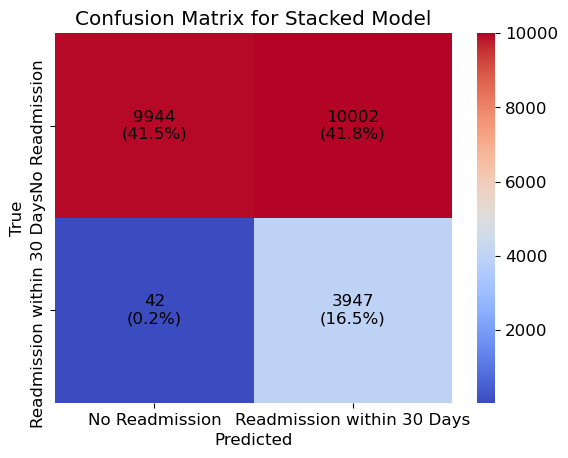


Stacked Model:
AUC: 0.98 (95% CI: 0.98-0.98)
Accuracy: 0.58 (95% CI: 0.57-0.59)
Sensitivity: 0.99 (95% CI: 0.99-0.99)
Specificity: 0.50 (95% CI: 0.49-0.51)
F1-Score: 0.44 (95% CI: 0.43-0.45)
Relative Risk: 67.28 (95% CI: 50.93-94.22)
Absolute Risk High: 0.2830 (95% CI: 0.2757-0.2909)
Absolute Risk Low: 0.0042 (95% CI: 0.0030-0.0056)
Attributable Risk: 0.2788 (95% CI: 0.2718-0.2861)
P-value for group comparison: 0.000000000
Testing performance results


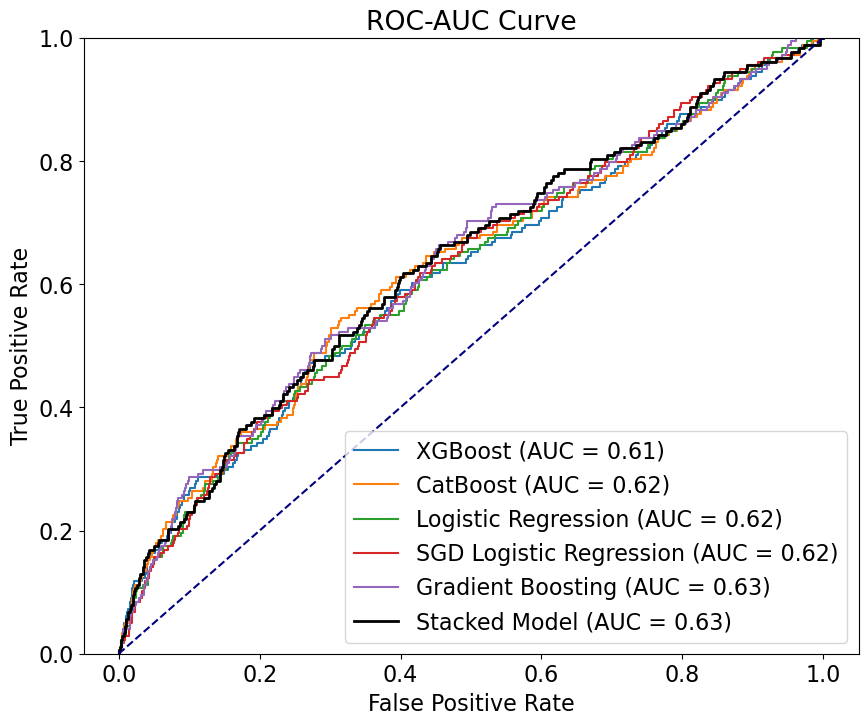

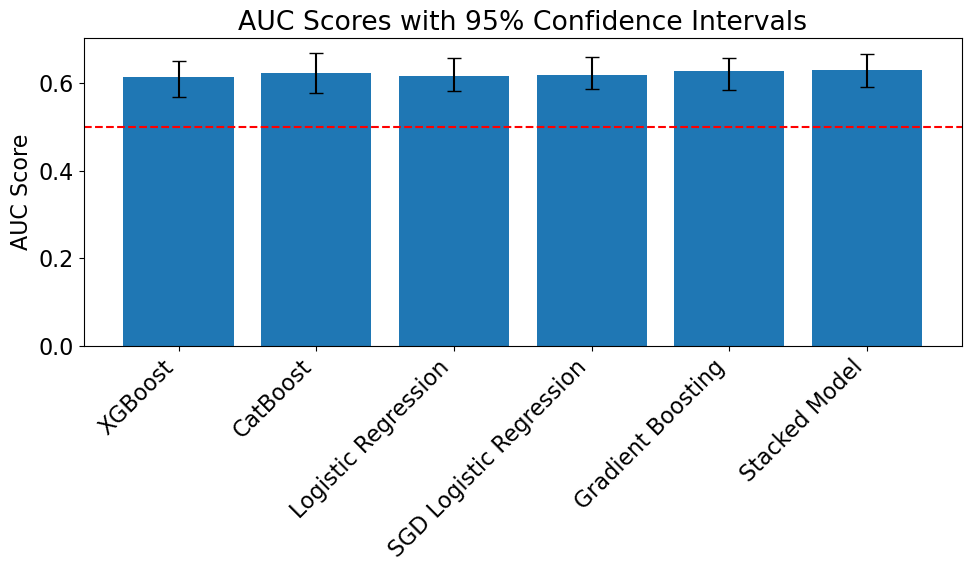

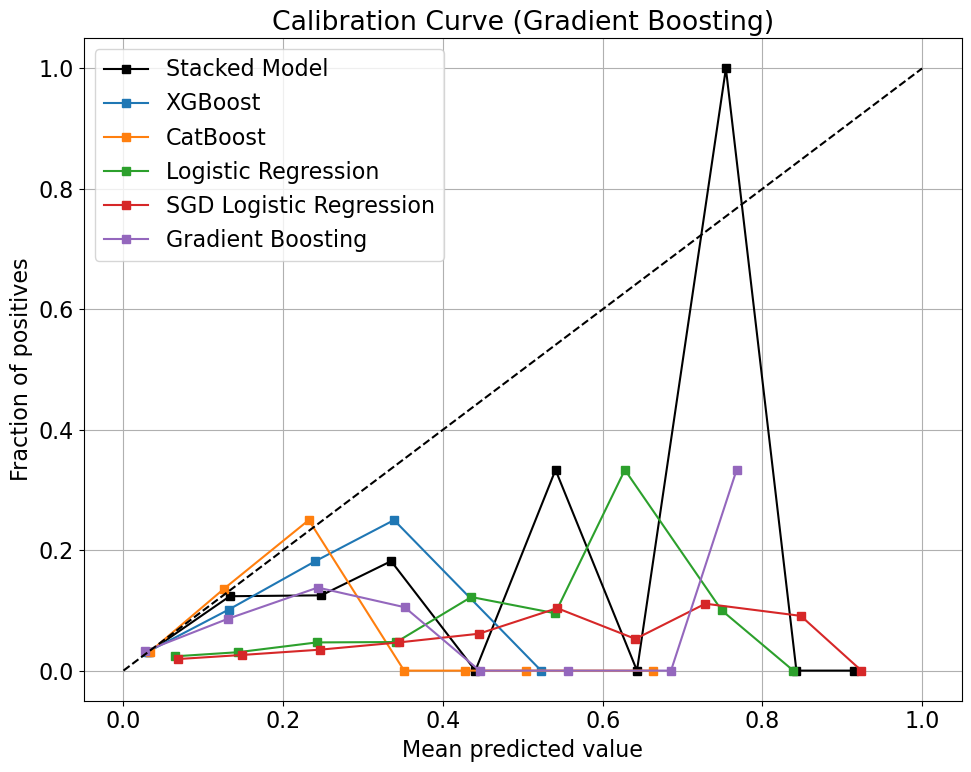

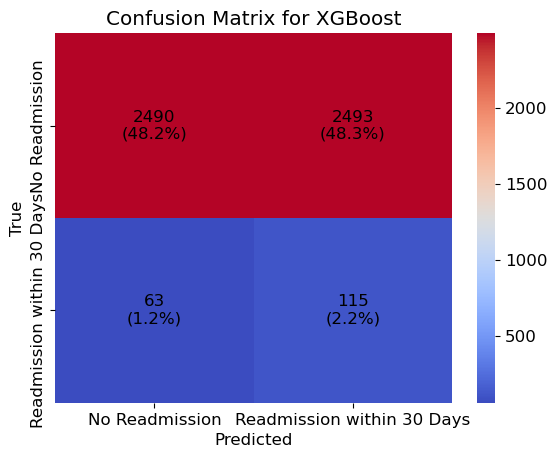


XGBoost:
AUC: 0.61 (95% CI: 0.57-0.65)
Accuracy: 0.50 (95% CI: 0.49-0.52)
Sensitivity: 0.64 (95% CI: 0.57-0.71)
Specificity: 0.50 (95% CI: 0.48-0.51)
F1-Score: 0.08 (95% CI: 0.07-0.09)
Relative Risk: 1.79 (95% CI: 1.27-2.38)
Absolute Risk High: 0.0441 (95% CI: 0.0366-0.0502)
Absolute Risk Low: 0.0247 (95% CI: 0.0197-0.0304)
Attributable Risk: 0.0194 (95% CI: 0.0082-0.0286)
P-value for group comparison: 0.000179818


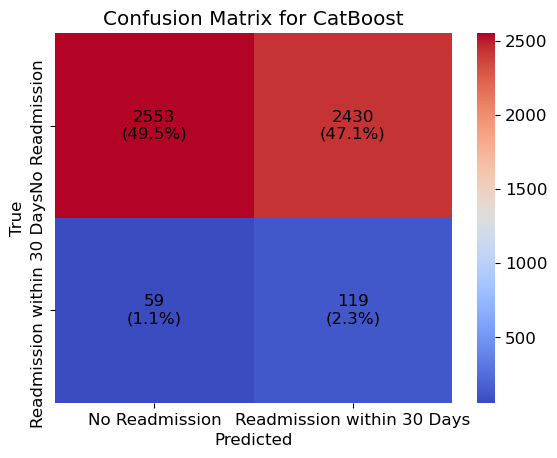


CatBoost:
AUC: 0.62 (95% CI: 0.58-0.67)
Accuracy: 0.52 (95% CI: 0.51-0.53)
Sensitivity: 0.66 (95% CI: 0.59-0.73)
Specificity: 0.51 (95% CI: 0.50-0.53)
F1-Score: 0.09 (95% CI: 0.07-0.10)
Relative Risk: 2.07 (95% CI: 1.51-2.83)
Absolute Risk High: 0.0467 (95% CI: 0.0378-0.0524)
Absolute Risk Low: 0.0226 (95% CI: 0.0172-0.0284)
Attributable Risk: 0.0241 (95% CI: 0.0137-0.0330)
P-value for group comparison: 0.000003062


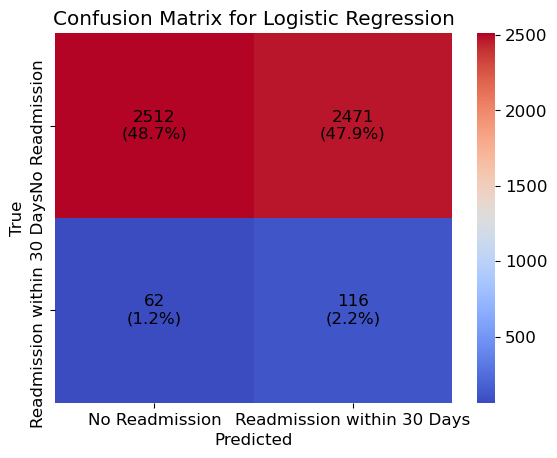


Logistic Regression:
AUC: 0.62 (95% CI: 0.58-0.66)
Accuracy: 0.51 (95% CI: 0.50-0.52)
Sensitivity: 0.65 (95% CI: 0.60-0.72)
Specificity: 0.50 (95% CI: 0.49-0.52)
F1-Score: 0.08 (95% CI: 0.07-0.10)
Relative Risk: 1.86 (95% CI: 1.44-2.56)
Absolute Risk High: 0.0448 (95% CI: 0.0388-0.0511)
Absolute Risk Low: 0.0241 (95% CI: 0.0191-0.0295)
Attributable Risk: 0.0208 (95% CI: 0.0126-0.0306)
P-value for group comparison: 0.000061065


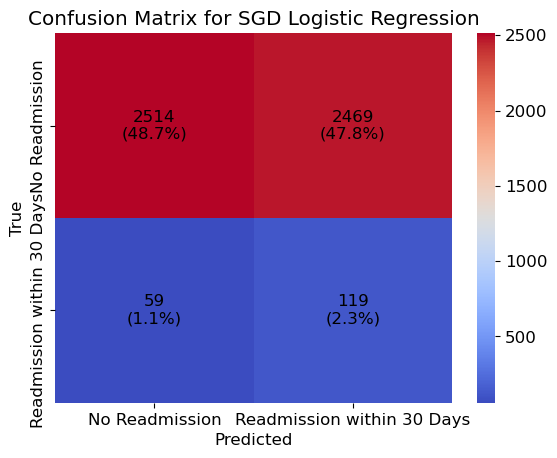


SGD Logistic Regression:
AUC: 0.62 (95% CI: 0.59-0.66)
Accuracy: 0.51 (95% CI: 0.50-0.53)
Sensitivity: 0.67 (95% CI: 0.61-0.73)
Specificity: 0.51 (95% CI: 0.49-0.52)
F1-Score: 0.09 (95% CI: 0.07-0.10)
Relative Risk: 2.01 (95% CI: 1.59-2.83)
Absolute Risk High: 0.0460 (95% CI: 0.0397-0.0520)
Absolute Risk Low: 0.0229 (95% CI: 0.0174-0.0276)
Attributable Risk: 0.0231 (95% CI: 0.0159-0.0328)
P-value for group comparison: 0.000008155


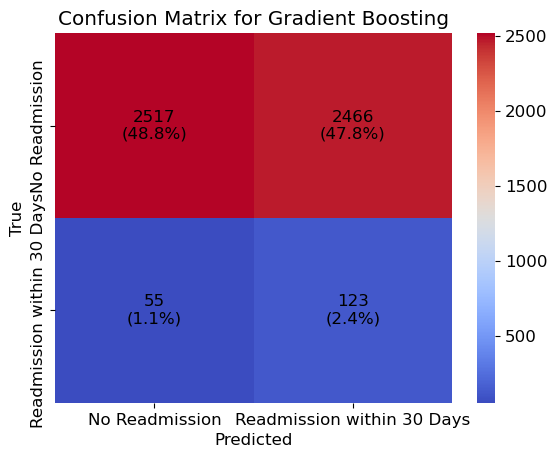


Gradient Boosting:
AUC: 0.62 (95% CI: 0.59-0.66)
Accuracy: 0.51 (95% CI: 0.50-0.53)
Sensitivity: 0.68 (95% CI: 0.62-0.75)
Specificity: 0.51 (95% CI: 0.49-0.52)
F1-Score: 0.09 (95% CI: 0.07-0.10)
Relative Risk: 2.22 (95% CI: 1.62-2.99)
Absolute Risk High: 0.0475 (95% CI: 0.0394-0.0535)
Absolute Risk Low: 0.0214 (95% CI: 0.0163-0.0265)
Attributable Risk: 0.0261 (95% CI: 0.0150-0.0345)
P-value for group comparison: 0.000000406


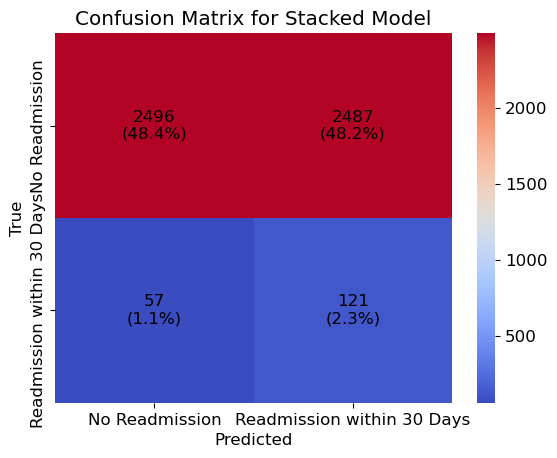


Stacked Model:
AUC: 0.63 (95% CI: 0.59-0.67)
Accuracy: 0.51 (95% CI: 0.49-0.52)
Sensitivity: 0.68 (95% CI: 0.61-0.73)
Specificity: 0.50 (95% CI: 0.49-0.52)
F1-Score: 0.09 (95% CI: 0.07-0.10)
Relative Risk: 2.08 (95% CI: 1.55-2.86)
Absolute Risk High: 0.0464 (95% CI: 0.0382-0.0519)
Absolute Risk Low: 0.0223 (95% CI: 0.0178-0.0269)
Attributable Risk: 0.0241 (95% CI: 0.0148-0.0327)
P-value for group comparison: 0.000003143


In [13]:
# # Load the variables back from the file
# with open('data_variables.pkl', 'rb') as f:
#     X_train, X_test, y_train, y_test = pickle.load(f)

# # Load stacked_model
# with open('trained_stacked_model.pkl', 'rb') as file:
#     trained_stacked_model = pickle.load(file)

# # Load all_models
# with open('trained_all_models.pkl', 'rb') as file:
#     trained_all_models = pickle.load(file)

print('Training performance results')
display_results(trained_stacked_model, trained_all_models, X_train, y_train, class_labels, target_fpr=0.5, plot_ci=False, n_bootstraps = n_bootstraps_for_results)

print('Testing performance results')
display_results(trained_stacked_model, trained_all_models, X_test, y_test, class_labels, target_fpr=0.5, plot_ci=False, n_bootstraps = n_bootstraps_for_results)

Training performance results


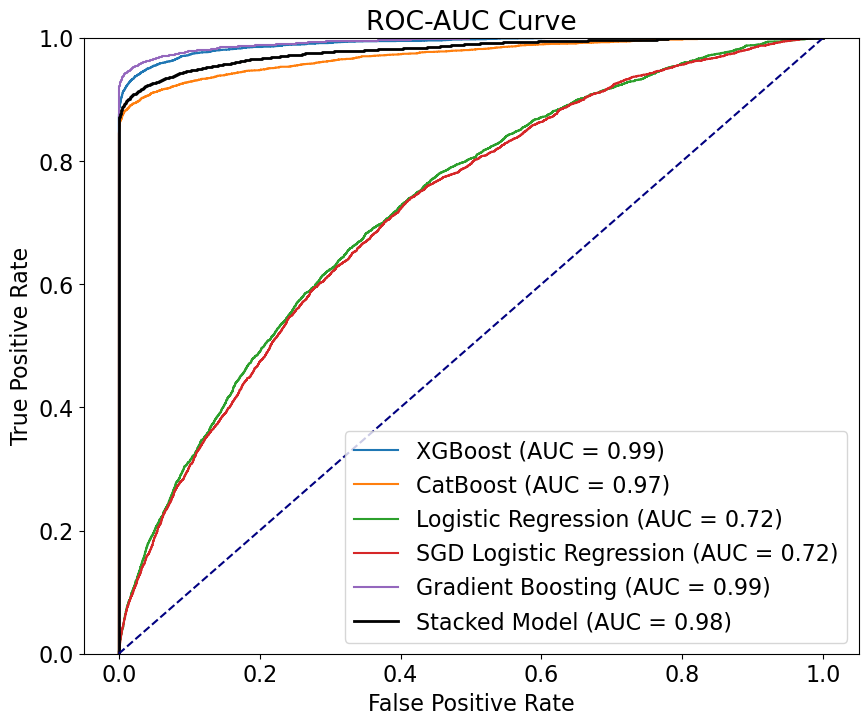

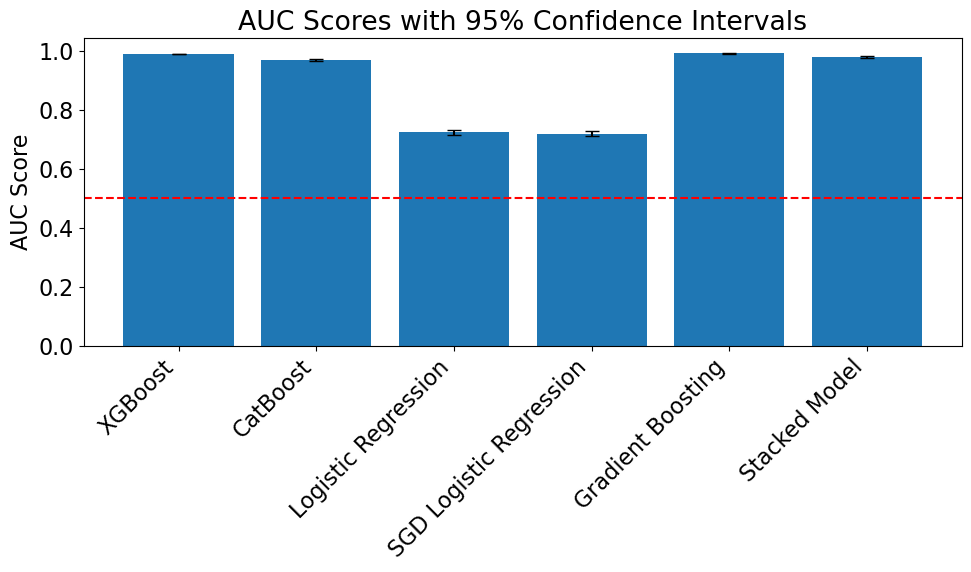

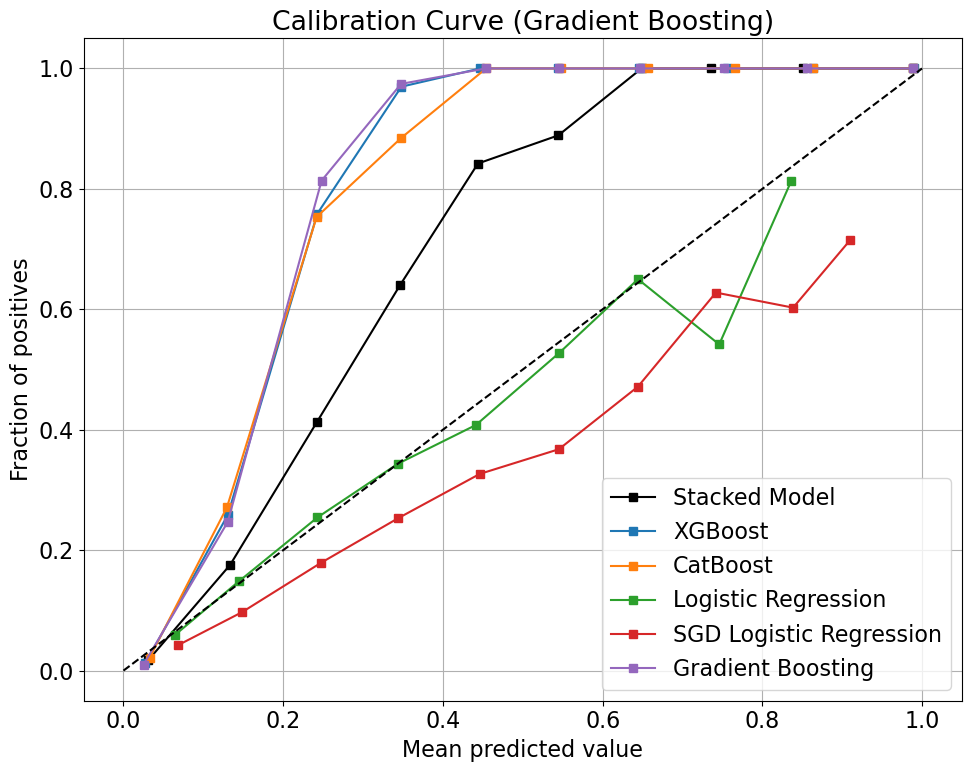

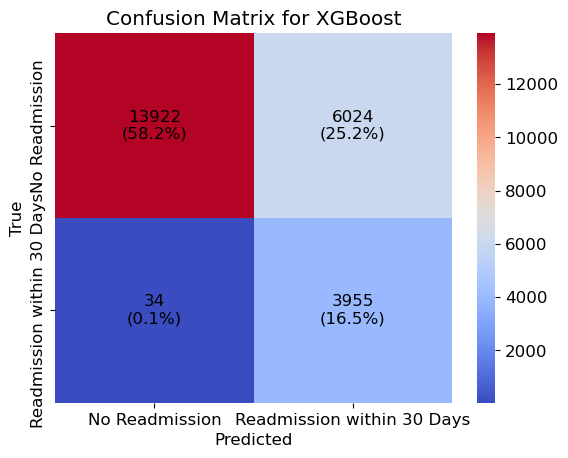


XGBoost:
AUC: 0.99 (95% CI: 0.99-0.99)
Accuracy: 0.75 (95% CI: 0.74-0.75)
Sensitivity: 0.99 (95% CI: 0.99-0.99)
Specificity: 0.70 (95% CI: 0.69-0.70)
F1-Score: 0.57 (95% CI: 0.56-0.58)
Relative Risk: 162.68 (95% CI: 120.44-253.91)
Absolute Risk High: 0.3963 (95% CI: 0.3879-0.4061)
Absolute Risk Low: 0.0024 (95% CI: 0.0016-0.0033)
Attributable Risk: 0.3939 (95% CI: 0.3857-0.4037)
P-value for group comparison: 0.000000000


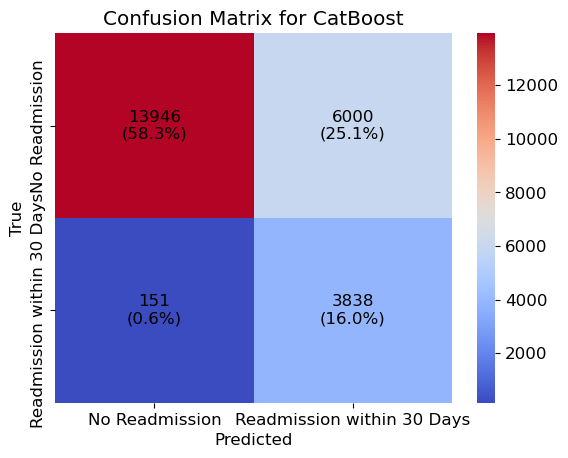


CatBoost:
AUC: 0.97 (95% CI: 0.97-0.97)
Accuracy: 0.74 (95% CI: 0.74-0.75)
Sensitivity: 0.96 (95% CI: 0.96-0.97)
Specificity: 0.70 (95% CI: 0.69-0.71)
F1-Score: 0.56 (95% CI: 0.55-0.57)
Relative Risk: 36.42 (95% CI: 31.60-41.47)
Absolute Risk High: 0.3901 (95% CI: 0.3810-0.3996)
Absolute Risk Low: 0.0107 (95% CI: 0.0094-0.0123)
Attributable Risk: 0.3794 (95% CI: 0.3708-0.3895)
P-value for group comparison: 0.000000000


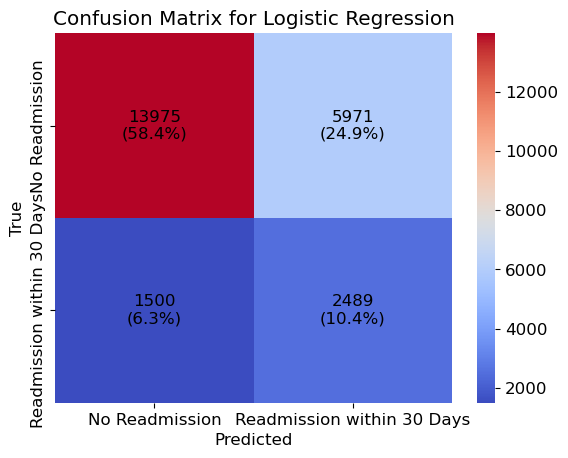


Logistic Regression:
AUC: 0.72 (95% CI: 0.72-0.73)
Accuracy: 0.69 (95% CI: 0.68-0.69)
Sensitivity: 0.62 (95% CI: 0.61-0.64)
Specificity: 0.70 (95% CI: 0.69-0.71)
F1-Score: 0.40 (95% CI: 0.39-0.41)
Relative Risk: 3.04 (95% CI: 2.88-3.24)
Absolute Risk High: 0.2942 (95% CI: 0.2859-0.3043)
Absolute Risk Low: 0.0969 (95% CI: 0.0926-0.1020)
Attributable Risk: 0.1973 (95% CI: 0.1881-0.2103)
P-value for group comparison: 0.000000000


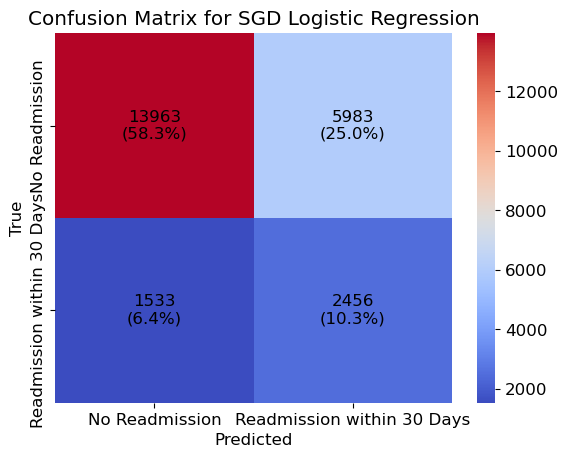


SGD Logistic Regression:
AUC: 0.72 (95% CI: 0.71-0.73)
Accuracy: 0.69 (95% CI: 0.68-0.69)
Sensitivity: 0.62 (95% CI: 0.60-0.63)
Specificity: 0.70 (95% CI: 0.69-0.71)
F1-Score: 0.40 (95% CI: 0.39-0.41)
Relative Risk: 2.94 (95% CI: 2.78-3.14)
Absolute Risk High: 0.2910 (95% CI: 0.2831-0.3012)
Absolute Risk Low: 0.0989 (95% CI: 0.0943-0.1034)
Attributable Risk: 0.1921 (95% CI: 0.1828-0.2041)
P-value for group comparison: 0.000000000


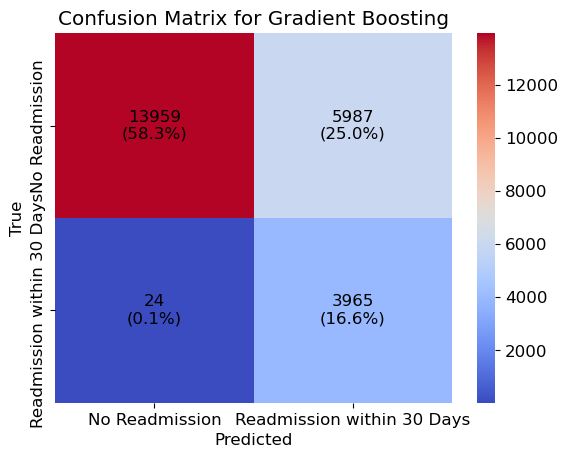


Gradient Boosting:
AUC: 0.99 (95% CI: 0.99-0.99)
Accuracy: 0.75 (95% CI: 0.74-0.75)
Sensitivity: 0.99 (95% CI: 0.99-1.00)
Specificity: 0.70 (95% CI: 0.69-0.71)
F1-Score: 0.57 (95% CI: 0.56-0.58)
Relative Risk: 232.13 (95% CI: 169.19-373.03)
Absolute Risk High: 0.3984 (95% CI: 0.3906-0.4064)
Absolute Risk Low: 0.0017 (95% CI: 0.0011-0.0024)
Attributable Risk: 0.3967 (95% CI: 0.3891-0.4046)
P-value for group comparison: 0.000000000


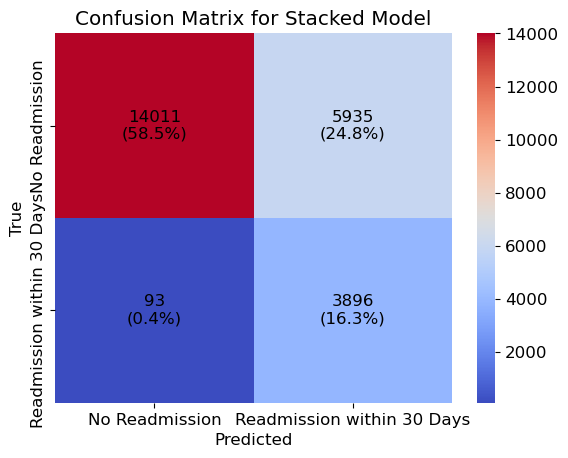


Stacked Model:
AUC: 0.98 (95% CI: 0.98-0.98)
Accuracy: 0.75 (95% CI: 0.74-0.75)
Sensitivity: 0.98 (95% CI: 0.97-0.98)
Specificity: 0.70 (95% CI: 0.70-0.71)
F1-Score: 0.56 (95% CI: 0.55-0.57)
Relative Risk: 60.10 (95% CI: 50.11-71.92)
Absolute Risk High: 0.3963 (95% CI: 0.3864-0.4052)
Absolute Risk Low: 0.0066 (95% CI: 0.0055-0.0079)
Attributable Risk: 0.3897 (95% CI: 0.3793-0.3988)
P-value for group comparison: 0.000000000
Testing performance results


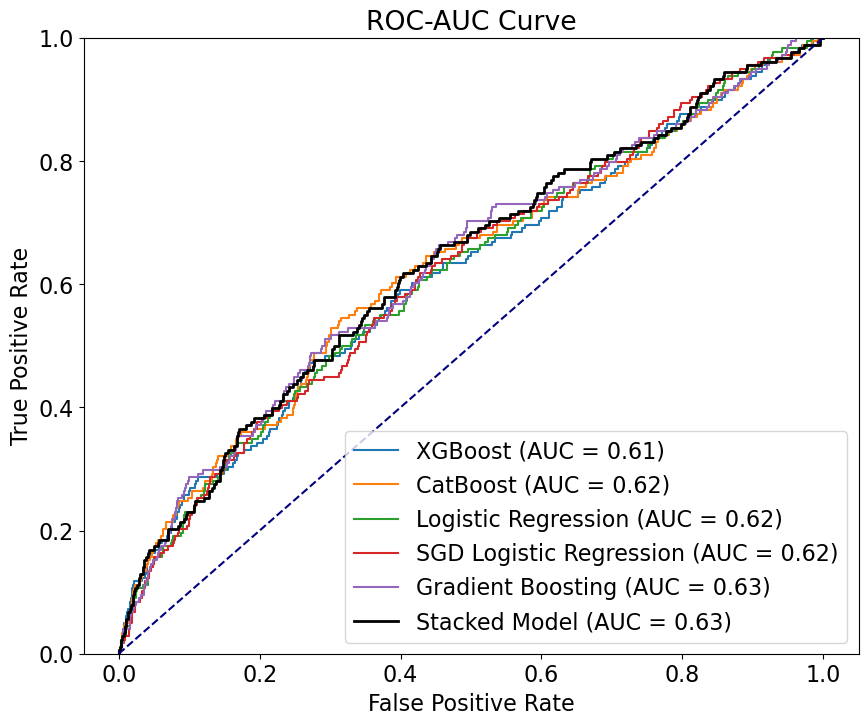

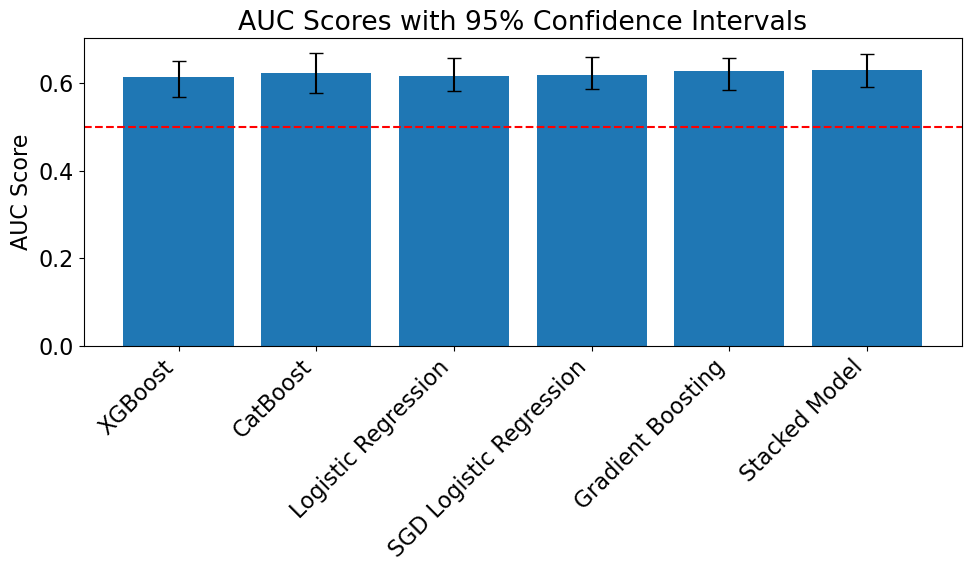

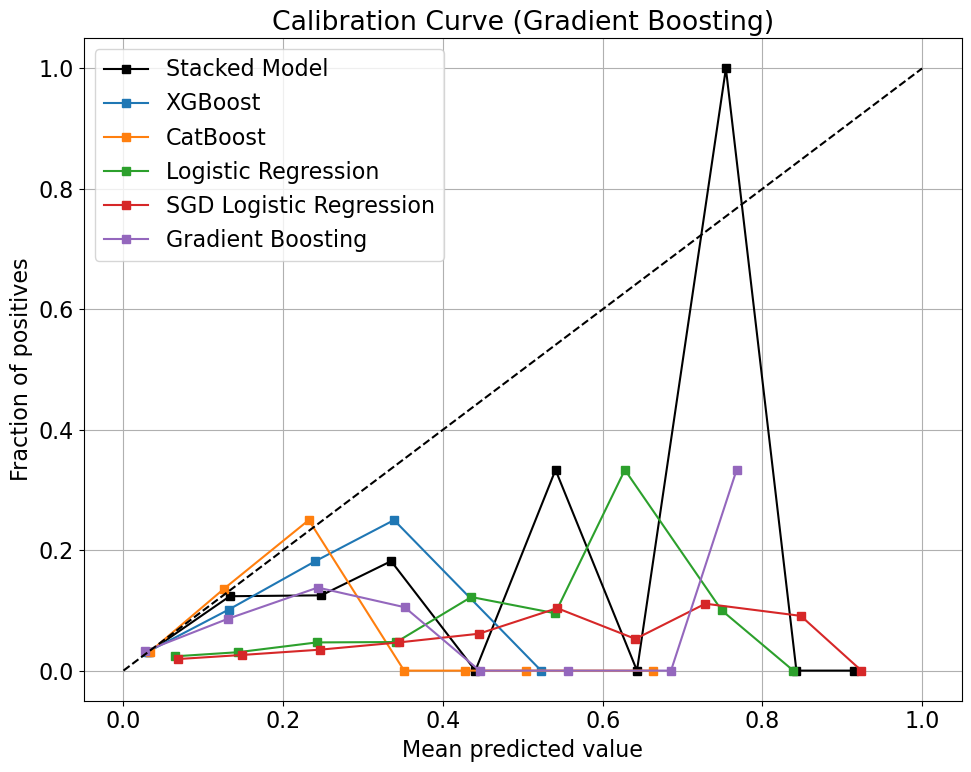

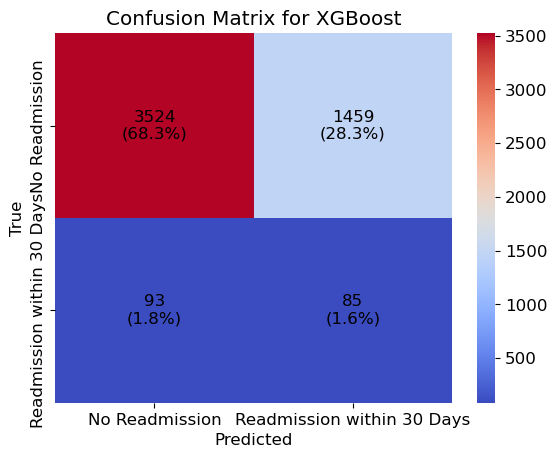


XGBoost:
AUC: 0.61 (95% CI: 0.57-0.65)
Accuracy: 0.70 (95% CI: 0.69-0.71)
Sensitivity: 0.47 (95% CI: 0.41-0.54)
Specificity: 0.71 (95% CI: 0.70-0.72)
F1-Score: 0.10 (95% CI: 0.08-0.12)
Relative Risk: 2.14 (95% CI: 1.65-2.84)
Absolute Risk High: 0.0551 (95% CI: 0.0437-0.0654)
Absolute Risk Low: 0.0257 (95% CI: 0.0218-0.0301)
Attributable Risk: 0.0293 (95% CI: 0.0175-0.0409)
P-value for group comparison: 0.000000193


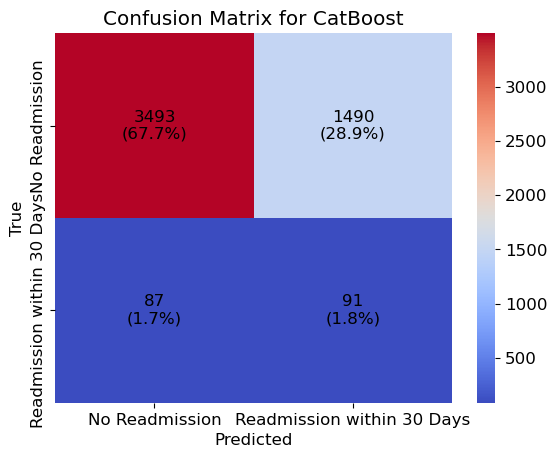


CatBoost:
AUC: 0.62 (95% CI: 0.58-0.67)
Accuracy: 0.69 (95% CI: 0.68-0.71)
Sensitivity: 0.51 (95% CI: 0.44-0.58)
Specificity: 0.70 (95% CI: 0.69-0.71)
F1-Score: 0.10 (95% CI: 0.08-0.12)
Relative Risk: 2.37 (95% CI: 1.79-3.16)
Absolute Risk High: 0.0576 (95% CI: 0.0465-0.0686)
Absolute Risk Low: 0.0243 (95% CI: 0.0194-0.0289)
Attributable Risk: 0.0333 (95% CI: 0.0208-0.0456)
P-value for group comparison: 0.000000003


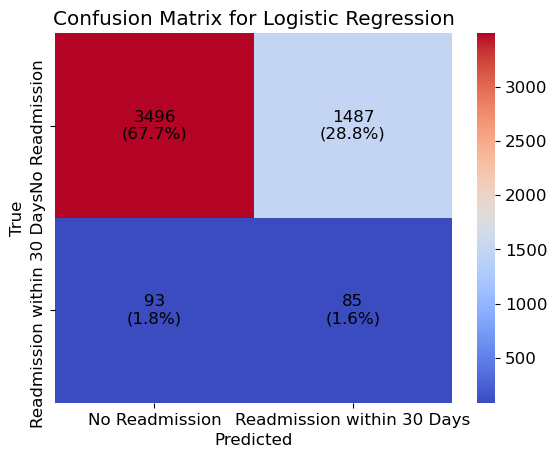


Logistic Regression:
AUC: 0.62 (95% CI: 0.58-0.66)
Accuracy: 0.69 (95% CI: 0.68-0.71)
Sensitivity: 0.48 (95% CI: 0.41-0.55)
Specificity: 0.70 (95% CI: 0.69-0.71)
F1-Score: 0.10 (95% CI: 0.08-0.11)
Relative Risk: 2.09 (95% CI: 1.63-2.77)
Absolute Risk High: 0.0541 (95% CI: 0.0418-0.0635)
Absolute Risk Low: 0.0259 (95% CI: 0.0209-0.0300)
Attributable Risk: 0.0282 (95% CI: 0.0163-0.0391)
P-value for group comparison: 0.000000519


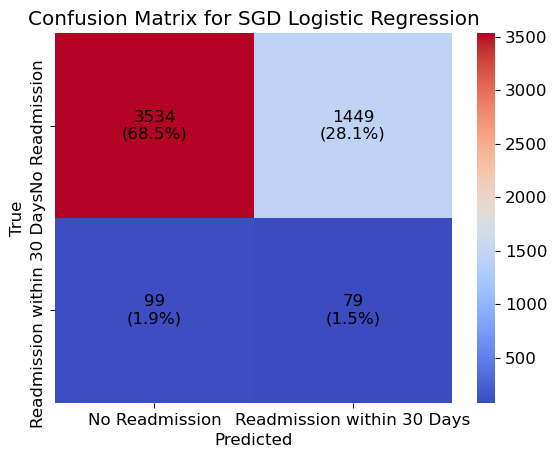


SGD Logistic Regression:
AUC: 0.62 (95% CI: 0.59-0.66)
Accuracy: 0.70 (95% CI: 0.69-0.71)
Sensitivity: 0.45 (95% CI: 0.38-0.52)
Specificity: 0.71 (95% CI: 0.70-0.72)
F1-Score: 0.09 (95% CI: 0.07-0.11)
Relative Risk: 1.90 (95% CI: 1.49-2.53)
Absolute Risk High: 0.0517 (95% CI: 0.0410-0.0618)
Absolute Risk Low: 0.0273 (95% CI: 0.0229-0.0316)
Attributable Risk: 0.0245 (95% CI: 0.0139-0.0369)
P-value for group comparison: 0.000016255


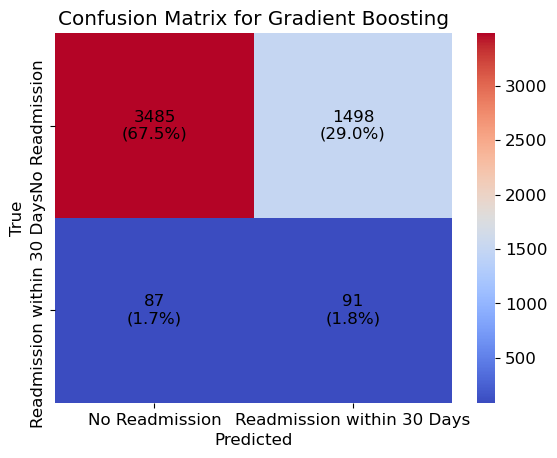


Gradient Boosting:
AUC: 0.62 (95% CI: 0.59-0.66)
Accuracy: 0.69 (95% CI: 0.68-0.71)
Sensitivity: 0.50 (95% CI: 0.45-0.57)
Specificity: 0.70 (95% CI: 0.69-0.71)
F1-Score: 0.10 (95% CI: 0.09-0.12)
Relative Risk: 2.35 (95% CI: 1.87-2.87)
Absolute Risk High: 0.0573 (95% CI: 0.0471-0.0661)
Absolute Risk Low: 0.0244 (95% CI: 0.0207-0.0286)
Attributable Risk: 0.0329 (95% CI: 0.0222-0.0428)
P-value for group comparison: 0.000000004


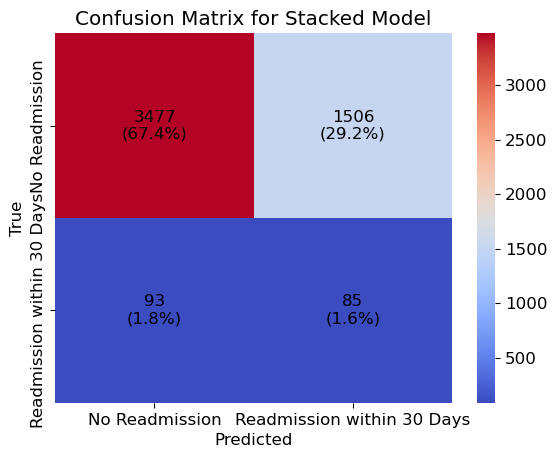


Stacked Model:
AUC: 0.63 (95% CI: 0.59-0.67)
Accuracy: 0.69 (95% CI: 0.68-0.71)
Sensitivity: 0.48 (95% CI: 0.39-0.55)
Specificity: 0.70 (95% CI: 0.69-0.71)
F1-Score: 0.10 (95% CI: 0.07-0.11)
Relative Risk: 2.05 (95% CI: 1.51-2.69)
Absolute Risk High: 0.0534 (95% CI: 0.0411-0.0630)
Absolute Risk Low: 0.0261 (95% CI: 0.0214-0.0301)
Attributable Risk: 0.0274 (95% CI: 0.0139-0.0394)
P-value for group comparison: 0.000000988


In [14]:
# # Target FPR 0.3

# print('Training performance results')
# display_results(trained_stacked_model, trained_all_models, X_train, y_train, class_labels, target_fpr=0.3, plot_ci=False, n_bootstraps = n_bootstraps_for_results)

# print('Testing performance results')
# display_results(trained_stacked_model, trained_all_models, X_test, y_test, class_labels, target_fpr=0.3, plot_ci=False, n_bootstraps = n_bootstraps_for_results)

In [19]:
def subgroup_analysis(subgroup_column, variable_type, trained_stacked_model, trained_all_models, X_test, y_test):
    if not isinstance(X_test, pd.DataFrame):
        raise ValueError("X_test must be a pandas DataFrame.")

    # Initializing variables to store results
    subgroups = []
    model_names = ['Stacked Model'] + list(trained_all_models.keys())
    auc_scores_dict = {model_name: [] for model_name in model_names}
    
    def compute_auc_scores(subgroup_indices):
        for model_name in auc_scores_dict.keys():
            if model_name == 'Stacked Model':
                model = trained_stacked_model
            else:
                model = trained_all_models[model_name]
            auc_score = roc_auc_score(y_test[subgroup_indices], model.predict_proba(X_test.iloc[subgroup_indices])[:, 1])
            auc_scores_dict[model_name].append(auc_score)
    
    if variable_type == 'continuous':
        split_value = 0  # Assuming normalization to mean=0
        
        # Splitting the data into subgroups
        index_below = np.where(X_test[subgroup_column] <= split_value)[0]
        index_above = np.where(X_test[subgroup_column] > split_value)[0]

        # Compute AUC for each subgroup
        compute_auc_scores(index_below)
        compute_auc_scores(index_above)
        
        subgroups = ['Below or Equal Mean', 'Above Mean']

    elif variable_type == 'categorical':
        categories = [col.split('_')[-1] for col in X_test.columns if subgroup_column in col]
        others_auc_scores = {model_name: [] for model_name in model_names}
        
        for category in categories:
            column_name = f"{subgroup_column}_{category}"
            if column_name in X_test.columns:
                index_cat = np.where(X_test[column_name] == 1)[0]

                # Compute AUC for the subgroup or add to "Other"
                if len(index_cat) / len(X_test) < 0.01:
                    for model_name in others_auc_scores.keys():
                        others_auc_scores[model_name].append(roc_auc_score(y_test[index_cat], trained_all_models[model_name].predict_proba(X_test.iloc[index_cat])[:, 1] if model_name != 'Stacked Model' else trained_stacked_model.predict_proba(X_test.iloc[index_cat])[:, 1]))
                else:
                    compute_auc_scores(index_cat)
                    subgroups.append(category)

        # Handle "Other" category
        if any(others_auc_scores[model_name] for model_name in model_names):
            subgroups.append("Other")
            for model_name, scores in others_auc_scores.items():
                auc_scores_dict[model_name].append(np.mean(scores))

    else:
        raise ValueError("variable_type must be either 'continuous' or 'categorical'.")

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.1  # Width of each bar
    x = np.arange(len(subgroups))
    
    for i, model_name in enumerate(model_names):
        if model_name == 'Stacked Model':
            ax.bar(x - 0.2 + i*width, auc_scores_dict[model_name], width, color='black', label=model_name)
        else:
            ax.bar(x - 0.2 + i*width, auc_scores_dict[model_name], width, label=model_name)
    
    ax.set_xlabel('Subgroup')
    ax.set_ylabel('AUC')
    ax.set_title(f'AUC by Subgroup for {subgroup_column}')
    ax.set_xticks(x)
    ax.set_xticklabels(subgroups, rotation=45)
#     ax.legend()
    ax.legend(loc='lower center', fontsize='small')

    
    plt.tight_layout()
    plt.ylim([0,1.0])
    plt.show()

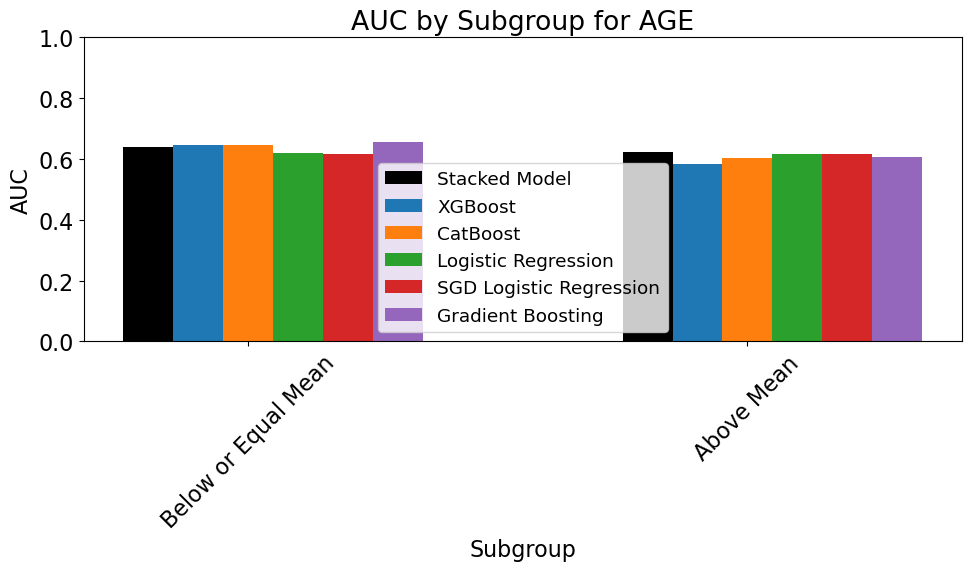

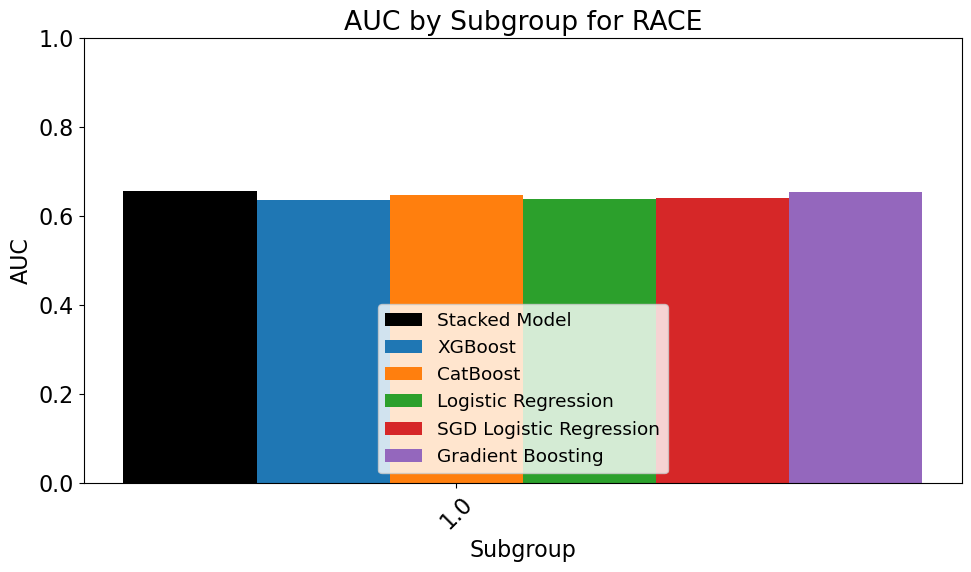

In [20]:
# For continuous variable AGE
subgroup_analysis('AGE', 'continuous', trained_stacked_model,trained_all_models, X_test, y_test)

# For categorical variable RACE
subgroup_analysis('RACE', 'categorical', trained_stacked_model,trained_all_models, X_test, y_test)

In [16]:
race_columns = [col for col in X_test.columns if "RACE_" in col]
print(race_columns)

['RACE_1.0']


PermutationExplainer explainer: 5162it [56:40,  1.52it/s]                       


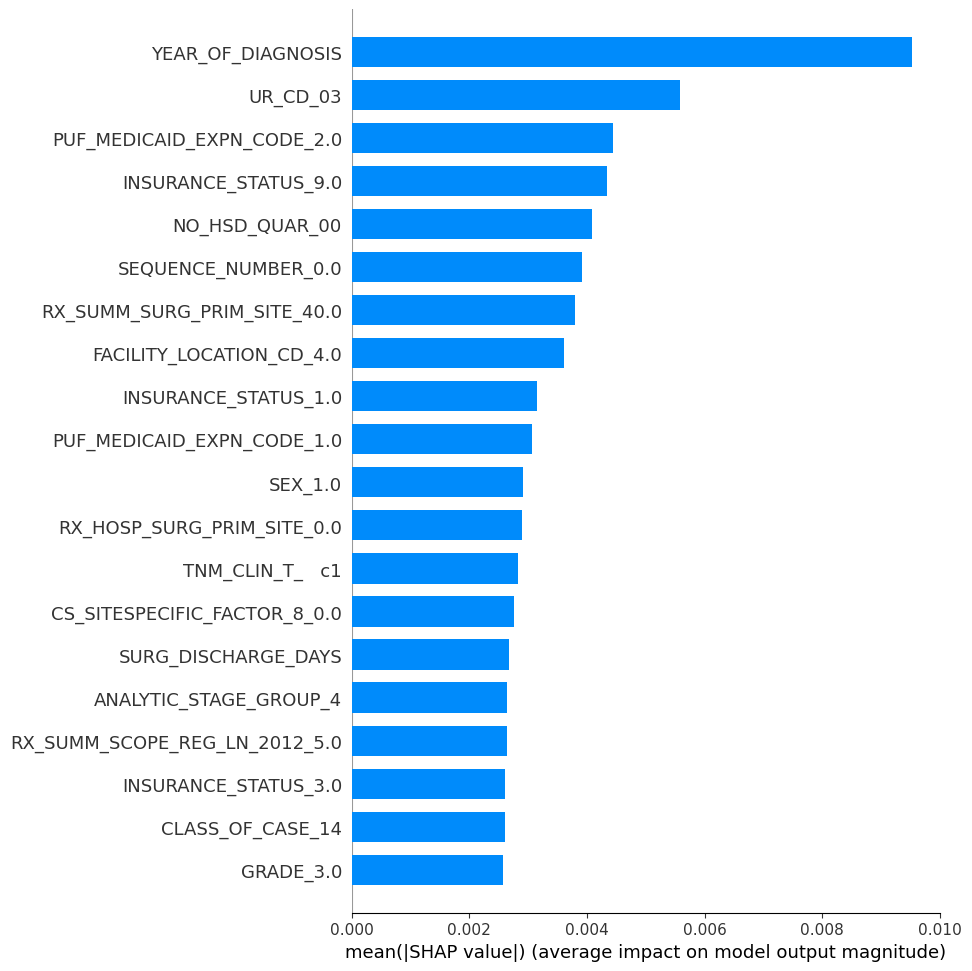

In [17]:
save_filename = f'{experiment_name}_{model_name}_shap.pkl'

if use_mini_dataset: 
    explainer, shap_values = model_interpretability(trained_stacked_model, X_small, y_small, save_filename)
else:
    explainer, shap_values = model_interpretability(trained_stacked_model, X_test, y_test, save_filename)

In [18]:
# Record the end time
end_time = datetime.datetime.now()

# Calculate the total runtime
total_runtime = end_time - start_time

# Convert total runtime to a format of days, hours, minutes, and seconds
formatted_runtime = str(total_runtime).split('.')[0]  # Remove microseconds

print(f"Total runtime: {formatted_runtime}")

Total runtime: 1:05:42
